# Human brain MTG cells

We localized human brain middle temporal gyrus (MTG) scRNA-seq dataset on huamn dorsolateral prefrontal cortex (DLPFC) 10x Visium ST dataset section 151673 to recover the laminor organization. The raw ST dataset is available at [Github](https://github.com/LieberInstitute/spatialLIBD). The raw scRNA-seq dataset is available at [Allen Brain Atlas](https://portal.brain-map.org/atlases-and-data/rnaseq/human-mtg-10x_sea-ad). The down-sampled barcodes and anndata object of down-sampled scRNA-seq dataset can be downloaded from [Google Drive](https://drive.google.com/drive/folders/1jVJsrXb6a4Hs4UmnDCTxp2OKqcRu3nRZ).

In [1]:
import warnings
warnings.filterwarnings("ignore")
import os
import numpy as np
import pandas as pd
import scanpy as sc
import STALOC
import scipy.sparse as sp

## Read data

In [2]:
st_data_path = '../data/T2_ST/'
adata_ST = sc.read_visium(path=st_data_path, count_file='filtered_feature_bc_matrix.h5')
adata_ST.var_names_make_unique()
Ann_df = pd.read_csv(os.path.join(st_data_path, '151673_truth.txt'), sep='\t', header=None, index_col=0)
Ann_df.columns = ['Ground Truth']
adata_ST.obs['layer'] = Ann_df.loc[adata_ST.obs_names, 'Ground Truth']
adata_ST.obs['celltype'] = Ann_df.loc[adata_ST.obs_names, 'Ground Truth']
adata_ST.uns['layer_colors']=['#1f77b4', '#ff7f0e', '#49b192', '#d62728', '#aa40fc', '#8c564b', '#e377c2']
adata_ST.uns['celltype_colors']=['#1f77b4', '#ff7f0e', '#49b192', '#d62728', '#aa40fc', '#8c564b', '#e377c2']
adata_ST=adata_ST[adata_ST.obs['layer'].isna()==False]

In [3]:
adata_ST

View of AnnData object with n_obs × n_vars = 3611 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'layer', 'celltype'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial', 'layer_colors', 'celltype_colors'
    obsm: 'spatial'

In [4]:
sc_data_path="../data/T2_sc/"
adata_sc=sc.read_h5ad(os.path.join(sc_data_path,"Reference_MTG_RNAseq_all-nuclei.2022-06-07.h5ad"))
adata_sc.obs["celltype"]=adata_sc.obs["subclass_label"]
del adata_sc.obs["GA_QCpass"]
del adata_sc.obs["CA_QCpass"]
used_barcode=pd.read_csv(os.path.join(sc_data_path,"MTG_barcode_down_1w.txt"), header=None)[0]
adata_sc=adata_sc[used_barcode]

In [ ]:
#sc_data_path="../data/T2_sc/"
#adata_sc=sc.read(os.path.join(sc_data_path, "MTG_scRNAseq_down_1w.h5ad"))

In [5]:
adata_sc

View of AnnData object with n_obs × n_vars = 10000 × 36601
    obs: 'sample_name', 'donor_sex_label', 'external_donor_name_label', 'species_label', 'age_label', 'region_label', 'cortical_layer_label', 'full_genotype_label', 'QCpass', 'cluster_label', 'cluster_confidence', 'subclass_label', 'subclass_confidence', 'class_label', 'class_confidence', 'GA_cluster_label', 'GA_subclass_label', 'GA_neighborhood_label', 'CA_cluster_label', 'CA_subclass_label', 'CA_neighborhood_label', 'cluster_color', 'cluster_order', 'subclass_color', 'subclass_order', 'class_color', 'class_order', 'GA_cluster_color', 'GA_cluster_order', 'GA_subclass_color', 'GA_subclass_order', 'CA_cluster_color', 'CA_cluster_order', 'CA_subclass_color', 'CA_subclass_order', 'cell_type_accession_label', 'celltype'

In [6]:
sc.pp.filter_genes(adata_ST, min_cells=3)
sc.pp.filter_genes(adata_sc, min_cells=3)

## Run model

In [7]:
experiment_path="T2_MTG"
if not os.path.exists(experiment_path):
    os.makedirs(experiment_path)

In [8]:
model = STALOC.model.Model(resolution="low", batch_size=200, train_epoch=10000, cut_steps=0.5, 
                           sf_coord = 6000, rad_cutoff=140/np.sqrt(3), 
                           seed=123, lambdacos = 2, lambdaSWD = 5, lambdalat = 10, lambdarec = 0.1,
                           model_path = "T2_MTG/models", data_path = "T2_MTG/data", result_path = "T2_MTG/results")

In [9]:
model.preprocess(adata_sc, adata_ST)

Finding highly variable genes...
Normalizing and scaling...
Dimensionality reduction via PCA...


In [10]:
model.train()

Begining time:  Wed Sep 20 19:34:57 2023
step 0, total_loss=474.8227, loss_D=6.1292, loss_GAN=6.7903, loss_AE=23.9813, loss_cos=2.0092, loss_LA=19.1884, loss_SWD=6.4635
step 500, total_loss=17.2235, loss_D=1.4648, loss_GAN=4.8494, loss_AE=0.7314, loss_cos=1.2334, loss_LA=0.1588, loss_SWD=0.2012
step 1000, total_loss=14.4936, loss_D=1.7330, loss_GAN=3.9829, loss_AE=0.6393, loss_cos=1.1376, loss_LA=0.0924, loss_SWD=0.1838
step 1500, total_loss=14.0864, loss_D=1.9137, loss_GAN=3.9714, loss_AE=0.6374, loss_cos=1.1633, loss_LA=0.0755, loss_SWD=0.1320
step 2000, total_loss=12.8191, loss_D=1.7568, loss_GAN=3.8616, loss_AE=0.5704, loss_cos=1.0993, loss_LA=0.0642, loss_SWD=0.0826
step 2500, total_loss=13.0667, loss_D=1.6916, loss_GAN=4.2062, loss_AE=0.5708, loss_cos=1.0817, loss_LA=0.0641, loss_SWD=0.0697
step 3000, total_loss=13.0094, loss_D=1.9638, loss_GAN=3.9647, loss_AE=0.5725, loss_cos=1.1006, loss_LA=0.0644, loss_SWD=0.0949
step 3500, total_loss=12.8773, loss_D=2.1388, loss_GAN=3.9120, l

In [11]:
model.eval()

Localized scRNA-seq dataset has been saved!


In [12]:
adata_total = model.adata_total
adata_sc = model.adata_A_input
adata_ST = model.adata_B_input
adata_sc_keep = model.adata_A_keep

In [13]:
adata_sc_keep

AnnData object with n_obs × n_vars = 9741 × 31587
    obs: 'sample_name', 'donor_sex_label', 'external_donor_name_label', 'species_label', 'age_label', 'region_label', 'cortical_layer_label', 'full_genotype_label', 'QCpass', 'cluster_label', 'cluster_confidence', 'subclass_label', 'subclass_confidence', 'class_label', 'class_confidence', 'GA_cluster_label', 'GA_subclass_label', 'GA_neighborhood_label', 'CA_cluster_label', 'CA_subclass_label', 'CA_neighborhood_label', 'cluster_color', 'cluster_order', 'subclass_color', 'subclass_order', 'class_color', 'class_order', 'GA_cluster_color', 'GA_cluster_order', 'GA_subclass_color', 'GA_subclass_order', 'CA_cluster_color', 'CA_cluster_order', 'CA_subclass_color', 'CA_subclass_order', 'cell_type_accession_label', 'celltype', 'batch'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'log1p', 'spatial'
    obsm: 'loc', 'spatial'

## Visualization of the localization results

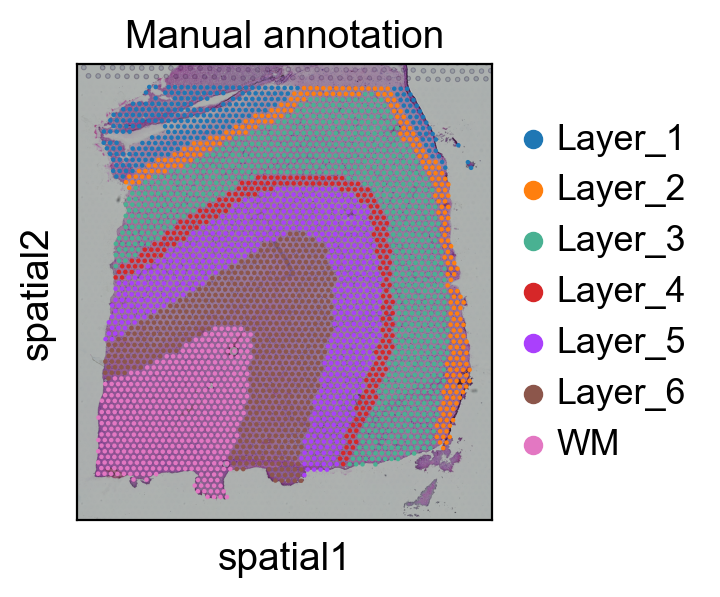

In [15]:
sc.set_figure_params(dpi=100, figsize=(3, 3))
sc.pl.spatial(adata_ST, img_key="hires", color="celltype", title="Manual annotation")

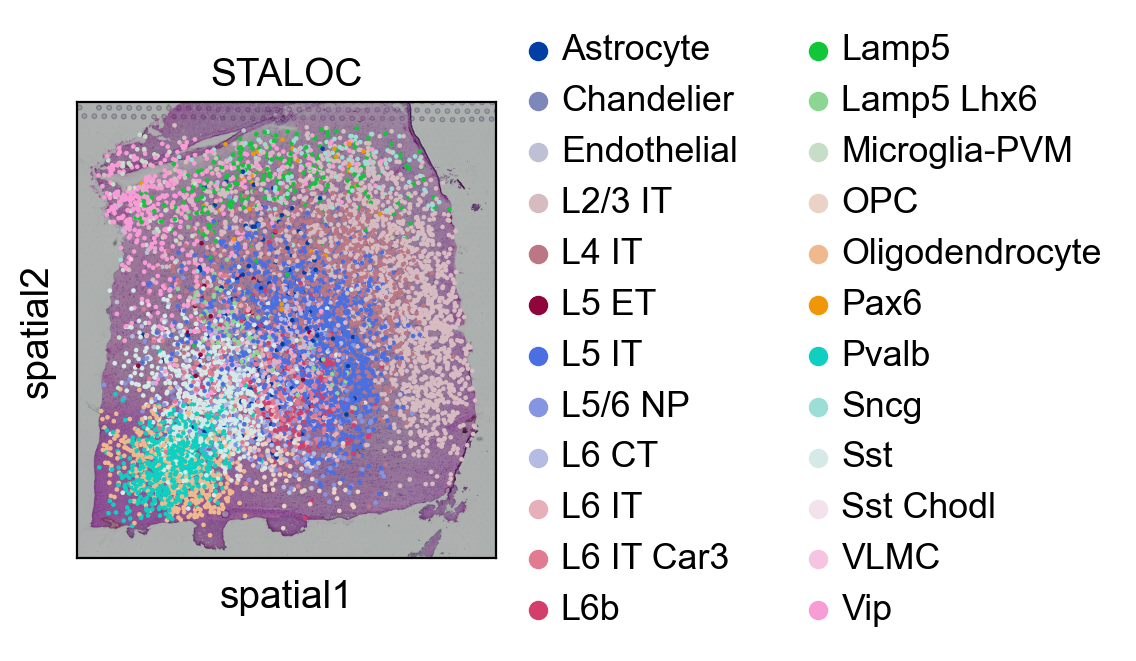

In [16]:
sc.set_figure_params(dpi=100, figsize=(3, 3))
sc.pl.spatial(adata_sc_keep, img_key="hires", color="celltype", title="STALOC")

## Spatial trajectory inference

This part needs [STAGATE](https://github.com/zhanglabtools/STAGATE) package.

In [17]:
import STAGATE
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

------Calculating spatial graph...
The graph contains 180760 edges, 9741 cells.
18.5566 neighbors per cell on average.


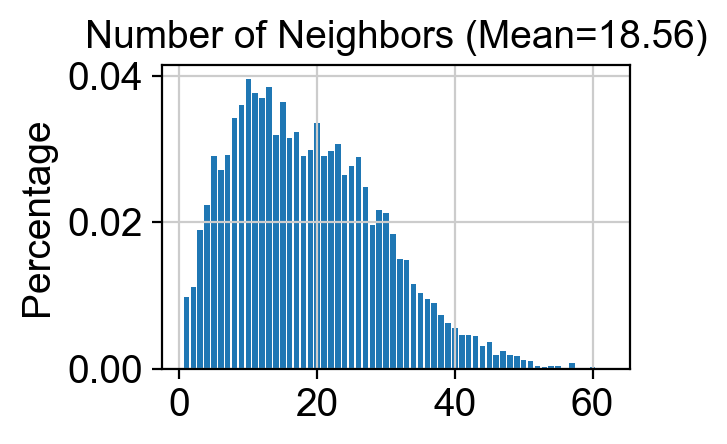

In [18]:
STAGATE.Cal_Spatial_Net(adata_sc_keep, rad_cutoff=150)
STAGATE.Stats_Spatial_Net(adata_sc_keep)

In [19]:
adata_sc_keep = STAGATE.train_STAGATE(adata_sc_keep, alpha=0)

Size of Input:  (9741, 4000)


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [16:40<00:00,  2.00s/it]


In [20]:
sc.pp.neighbors(adata_sc_keep, use_rep='STAGATE')
sc.tl.umap(adata_sc_keep)

<AxesSubplot:title={'center':'UMAP'}, xlabel='UMAP1', ylabel='UMAP2'>

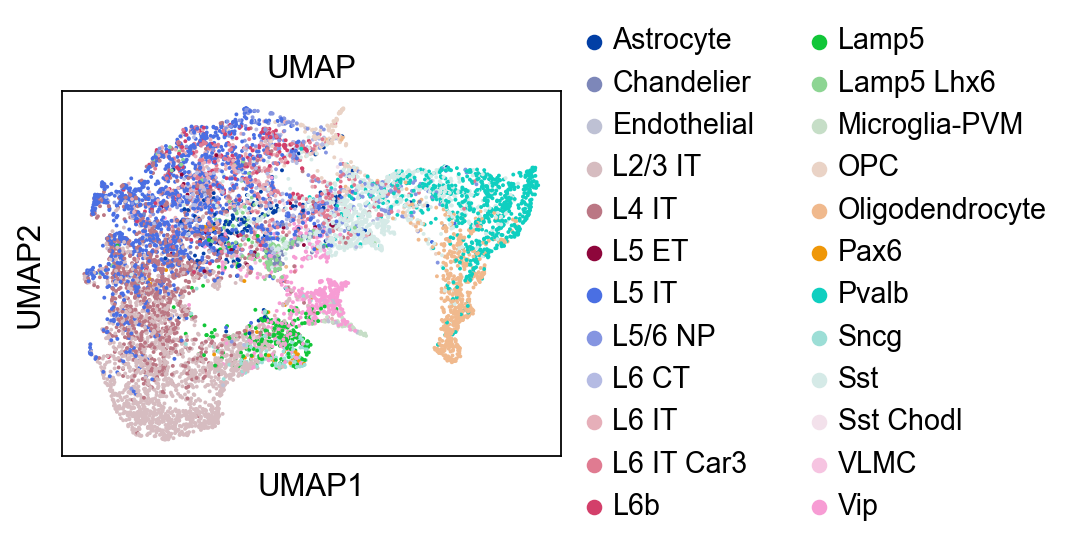

In [21]:
sc.set_figure_params(dpi=80, figsize=(4, 3))
sc.pl.umap(adata_sc_keep, show=False, color="celltype", legend_fontoutline=2, title="UMAP")

In [22]:
pop_label=model.cluster_score.columns
select_pop=pop_label[[10,4,6,11,15,1,16,18,9]]

In [23]:
select_adata_sc_keep=adata_sc_keep.copy()
select_adata_sc_keep=select_adata_sc_keep[select_adata_sc_keep.obs["celltype"].isin(select_pop)]

In [24]:
sc.tl.paga(select_adata_sc_keep, groups='celltype')

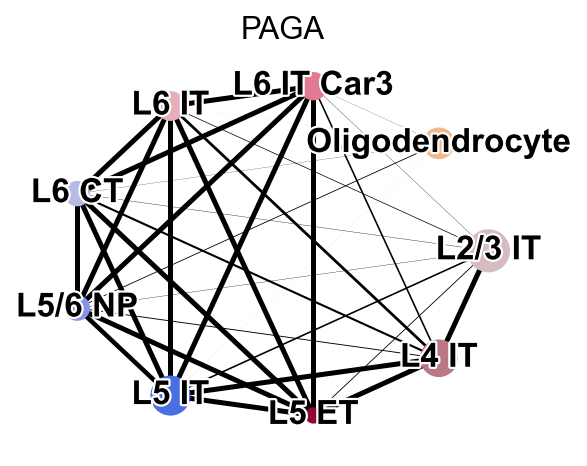

In [25]:
sc.set_figure_params(dpi=80, figsize=(4, 3))
sc.pl.paga(select_adata_sc_keep, fontsize=15, frameon=False, layout='circle', fontoutline=2, edge_width_scale=0.3, 
           threshold=0, show=True, title="PAGA")